<a href="https://colab.research.google.com/github/FanusArefaine/Fraud-Analysis-and-Detection/blob/master/Fraud_Analysis_and_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [96.1 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()
from pyspark import SparkContext

sc = SparkContext.getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [4]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import pandas as pd

# Importing the dataset from the local google drive directory
df = spark.read.csv('/content/drive/My Drive/colab_notes/datasets/Fraud_Detection_Dataset.csv', inferSchema=True, header=True)

# moving the dataset to the memory for faster computation
df.cache()

# showing or printing the first 10 elements in the dataset
df.show(10)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [13]:
# Checking on the top five elements using pandas dataframe -  a more prettier view
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### ***Summary Statistics for numeric features***

In [16]:
numeric_features = [x for (x,dataType) in df.dtypes if dataType == 'int' or dataType == 'double']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
step,6362620,243.39724563151657,142.33197104913066,1,743
amount,6362620,179861.9035491287,603858.2314629209,0.0,9.244551664E7
oldbalanceOrg,6362620,833883.1040744764,2888242.673037527,0.0,5.958504037E7
newbalanceOrig,6362620,855113.6685785812,2924048.5029542595,0.0,4.958504037E7
oldbalanceDest,6362620,1100701.6665196533,3399180.1129944525,0.0,3.5601588935E8
newbalanceDest,6362620,1224996.3982019224,3674128.9421196915,0.0,3.5617927892E8
isFraud,6362620,0.001290820448180152,0.035904796801604424,0,1
isFlaggedFraud,6362620,2.51468734577894E-6,0.0015857747057365457,0,1


In [17]:
# Slicing the features so that we can work with only part of the data for this classification problem
df = df.select("type", "amount", "oldbalanceOrg","newbalanceOrig", "isFraud")

In [18]:
# checking the schema along with the datatypes of the attributes
df.printSchema()

root
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- isFraud: integer (nullable = true)



In [19]:
# showing the dataset with new slice of features
df.show(2)

+-------+-------+-------------+--------------+-------+
|   type| amount|oldbalanceOrg|newbalanceOrig|isFraud|
+-------+-------+-------------+--------------+-------+
|PAYMENT|9839.64|     170136.0|     160296.36|      0|
|PAYMENT|1864.28|      21249.0|      19384.72|      0|
+-------+-------+-------------+--------------+-------+
only showing top 2 rows



In [20]:
# Slicing the numeric features
numeric_features = [x for (x,dataType) in df.dtypes if dataType == 'int' or dataType == 'double']

In [24]:
# Unique transactions in the dataset
df.count()

6362620

#### Spliting the dataset to train and test set before applying feature engineering techniques to the dataset

#### Applying 80:20 train to test set ratio for the split


# ***Train/Test Split*** 

In [25]:
train, test = df.randomSplit((0.8, 0.3), seed=42)

In [26]:
print(f"Train set length: {train.count()} records")
print(f"Test set length: {test.count()} records")

Train set length: 4626812 records
Test set length: 1735808 records


In [27]:
train.show(5)

+-------+------+-------------+--------------+-------+
|   type|amount|oldbalanceOrg|newbalanceOrig|isFraud|
+-------+------+-------------+--------------+-------+
|CASH_IN|  1.42|   1270713.41|    1270714.83|      0|
|CASH_IN|  5.19|      18104.0|      18109.19|      0|
|CASH_IN|  5.44|          0.0|          5.44|      0|
|CASH_IN|  5.66|   5061561.06|    5061566.72|      0|
|CASH_IN|  6.07|     400680.0|     400686.07|      0|
+-------+------+-------------+--------------+-------+
only showing top 5 rows



In [28]:
test.show(5)

+-------+------+-------------+--------------+-------+
|   type|amount|oldbalanceOrg|newbalanceOrig|isFraud|
+-------+------+-------------+--------------+-------+
|CASH_IN|  4.35|   4136277.22|    4136281.57|      0|
|CASH_IN|  4.58|      94241.0|      94245.58|      0|
|CASH_IN|  4.71|      50198.0|      50202.71|      0|
|CASH_IN|  9.02|   2416260.59|    2416269.61|      0|
|CASH_IN| 11.13|   4116439.74|    4116450.87|      0|
+-------+------+-------------+--------------+-------+
only showing top 5 rows



# ***Feature Engineering***

### **Encoding Categorical Features**

In [29]:
# Checking the datatypes of the training data
train.dtypes

[('type', 'string'),
 ('amount', 'double'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('isFraud', 'int')]

In [30]:
# Filtering categorical fetures from the dataset
catCols = [x for (x, dataType) in train.dtypes if dataType == "string"]
catCols

['type']

In [31]:
# Filtering numeric features, except the target feature(isFraud)

numCols = [x for (x, dataType) in train.dtypes if dataType=="double" and x != "isFraud"]
numCols

['amount', 'oldbalanceOrg', 'newbalanceOrig']

#### *One-Hot-Encoding*

In [32]:
# checking how many distict or unique values the 'type' feature has along with the number of elements these types represent
train.groupBy("type").count().show()

+--------+-------+
|    type|  count|
+--------+-------+
|TRANSFER| 387494|
| CASH_IN|1018367|
|CASH_OUT|1626504|
| PAYMENT|1564235|
|   DEBIT|  30212|
+--------+-------+



In [33]:
## changing the 'type' categories into one hot encoded representation 

from pyspark.ml.feature import OneHotEncoderEstimator, OneHotEncoderModel


In [34]:
from pyspark.ml.feature import OneHotEncoderEstimator, OneHotEncoderModel, StringIndexer

# The index of string vlaues multiple columns
indexers = [
    StringIndexer(inputCol=x, outputCol=x + "_StringIndexer", handleInvalid="skip")
    for x in catCols
]

In [35]:
indexers

[StringIndexer_41568167e16da8be47fd]

In [36]:
# Encoding 
encoders = [
            OneHotEncoderEstimator(
                inputCols=[f"{x}_StringIndexer" for x in catCols],
                outputCols=[f"{x}_OneHotEncoder" for x in catCols], 
    )
]

In [37]:
encoders

[OneHotEncoderEstimator_4284b4562fe60c55add5]

### **Vector Assembler**

In [38]:
# Converting the features into vectors for the machine learning algorithms
from pyspark.ml.feature import VectorAssembler

In [39]:
# The assembler will accept the numerical as well as the categorical input 

assemblerInput = [x for x in numCols]
assemblerInput += [f"{x}_OneHotEncoder" for x in catCols]

In [40]:
# assembler input sanity check
assemblerInput

['amount', 'oldbalanceOrg', 'newbalanceOrig', 'type_OneHotEncoder']

In [41]:
# applying vector assembler to all the features
vector_assembler = VectorAssembler(
    inputCols=assemblerInput, outputCol = "VectorAssembler_features"
)

In [42]:
stages = []
stages += indexers
stages += encoders
stages += [vector_assembler]

In [43]:
# Stages of feature engineering for the pipeline
stages

[StringIndexer_41568167e16da8be47fd,
 OneHotEncoderEstimator_4284b4562fe60c55add5,
 VectorAssembler_4afc8dcf1d74930bb53d]

In [44]:
%%time

# Defining the pipeline and fitting the training data 
from pyspark.ml import Pipeline

pipeline = Pipeline().setStages(stages)
model = pipeline.fit(train)

CPU times: user 15 ms, sys: 3.73 ms, total: 18.7 ms
Wall time: 15 s


In [45]:
train = model.transform(train)

In [46]:
# Checking the training transformed data

train.select(
    "type", "amount", "oldbalanceOrg", "newbalanceOrig", "VectorAssembler_features",
).show(5, truncate=False)

+-------+------+-------------+--------------+--------------------------------------------+
|type   |amount|oldbalanceOrg|newbalanceOrig|VectorAssembler_features                    |
+-------+------+-------------+--------------+--------------------------------------------+
|CASH_IN|1.42  |1270713.41   |1270714.83    |[1.42,1270713.41,1270714.83,0.0,0.0,1.0,0.0]|
|CASH_IN|5.19  |18104.0      |18109.19      |[5.19,18104.0,18109.19,0.0,0.0,1.0,0.0]     |
|CASH_IN|5.44  |0.0          |5.44          |(7,[0,2,5],[5.44,5.44,1.0])                 |
|CASH_IN|5.66  |5061561.06   |5061566.72    |[5.66,5061561.06,5061566.72,0.0,0.0,1.0,0.0]|
|CASH_IN|6.07  |400680.0     |400686.07     |[6.07,400680.0,400686.07,0.0,0.0,1.0,0.0]   |
+-------+------+-------------+--------------+--------------------------------------------+
only showing top 5 rows



In [47]:
# Transforming the test set on the same model the training dataset is fit
pp_df = model.transform(test)

In [48]:
# Checking the test transformed data

pp_df.select(
    "type", "amount", "oldbalanceOrg", "newbalanceOrig", "VectorAssembler_features",
).show(5, truncate=False)

+-------+------+-------------+--------------+---------------------------------------------+
|type   |amount|oldbalanceOrg|newbalanceOrig|VectorAssembler_features                     |
+-------+------+-------------+--------------+---------------------------------------------+
|CASH_IN|4.35  |4136277.22   |4136281.57    |[4.35,4136277.22,4136281.57,0.0,0.0,1.0,0.0] |
|CASH_IN|4.58  |94241.0      |94245.58      |[4.58,94241.0,94245.58,0.0,0.0,1.0,0.0]      |
|CASH_IN|4.71  |50198.0      |50202.71      |[4.71,50198.0,50202.71,0.0,0.0,1.0,0.0]      |
|CASH_IN|9.02  |2416260.59   |2416269.61    |[9.02,2416260.59,2416269.61,0.0,0.0,1.0,0.0] |
|CASH_IN|11.13 |4116439.74   |4116450.87    |[11.13,4116439.74,4116450.87,0.0,0.0,1.0,0.0]|
+-------+------+-------------+--------------+---------------------------------------------+
only showing top 5 rows



## **Building Model**

#### **Logistic Regression**

In [49]:
from pyspark.ml.classification import LogisticRegression

In [50]:
from pyspark.sql import functions as F

train_data = train.select(F.col("VectorAssembler_features").alias("features"),
    F.col("isFraud").alias("label")
)

test_data = pp_df.select(F.col("VectorAssembler_features").alias("features"),
    F.col("isFraud").alias("label")
)

In [51]:
train_data.show(5, truncate=False)

+--------------------------------------------+-----+
|features                                    |label|
+--------------------------------------------+-----+
|[1.42,1270713.41,1270714.83,0.0,0.0,1.0,0.0]|0    |
|[5.19,18104.0,18109.19,0.0,0.0,1.0,0.0]     |0    |
|(7,[0,2,5],[5.44,5.44,1.0])                 |0    |
|[5.66,5061561.06,5061566.72,0.0,0.0,1.0,0.0]|0    |
|[6.07,400680.0,400686.07,0.0,0.0,1.0,0.0]   |0    |
+--------------------------------------------+-----+
only showing top 5 rows



In [52]:
test_data.show(5, truncate=False)

+---------------------------------------------+-----+
|features                                     |label|
+---------------------------------------------+-----+
|[4.35,4136277.22,4136281.57,0.0,0.0,1.0,0.0] |0    |
|[4.58,94241.0,94245.58,0.0,0.0,1.0,0.0]      |0    |
|[4.71,50198.0,50202.71,0.0,0.0,1.0,0.0]      |0    |
|[9.02,2416260.59,2416269.61,0.0,0.0,1.0,0.0] |0    |
|[11.13,4116439.74,4116450.87,0.0,0.0,1.0,0.0]|0    |
+---------------------------------------------+-----+
only showing top 5 rows



In [53]:
%%time
model = LogisticRegression(maxIter=10).fit(train_data)

CPU times: user 31 ms, sys: 4.04 ms, total: 35.1 ms
Wall time: 1min 29s


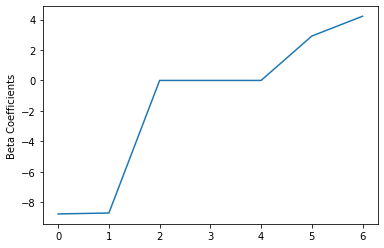

In [54]:
# Visualizing beta coefficients

import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

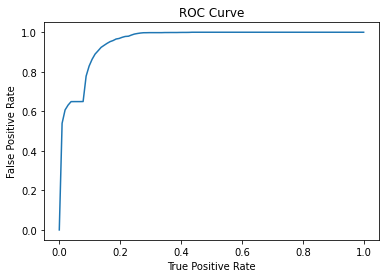

Training set areaUnderROC: 0.9541994522078049


In [56]:
# Evaluating Logistic Regression using ROC Curve

trainingSummary = model.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' +
      str(trainingSummary.areaUnderROC))

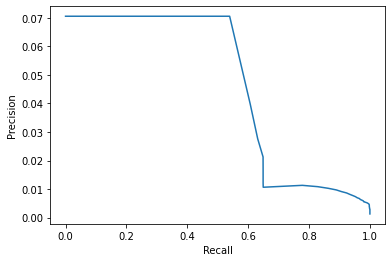

In [57]:
# Precision and Recall

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'], pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [58]:
# MAKING PREDICTIONS ON THE TEST SET

predictions = model.transform(test_data)
predictions.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[4.35,4136277.22,...|    0|[16.1147652581929...|[0.99999989966641...|       0.0|
|[4.58,94241.0,942...|    0|[17.8607125411645...|[0.99999998249383...|       0.0|
|[4.71,50198.0,502...|    0|[17.8797368973542...|[0.99999998282372...|       0.0|
|[9.02,2416260.59,...|    0|[16.8577254513155...|[0.99999995227094...|       0.0|
|[11.13,4116439.74...|    0|[16.1233390138053...|[0.99999990052297...|       0.0|
|[16.3,2.140511936...|    0|[8.65554229070319...|[0.99982587139707...|       0.0|
|[17.33,8964056.72...|    0|[14.0294279495163...|[0.99999919258557...|       0.0|
|(7,[0,2,5],[22.31...|    0|[17.9014327922638...|[0.99999998319236...|       0.0|
|[22.67,405940.0,4...|    0|[17.7260883228332...|[0.99999997997107...|       0.0|
|[34.58,26620.0,

In [59]:
# Final Evaluation of the logistic regression

from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC", evaluator.evaluate(predictions))

Test Area Under ROC 0.9566783744671705


## ***Decision Tree Classifier***

In [60]:
from pyspark.ml.classification import DecisionTreeClassifier

In [62]:
dt = DecisionTreeClassifier(maxDepth=3)
dtModel = dt.fit(train_data)
predictions = dtModel.transform(test_data) 
predictions.show()

+--------------------+-----+---------------+-----------+----------+
|            features|label|  rawPrediction|probability|prediction|
+--------------------+-----+---------------+-----------+----------+
|[4.35,4136277.22,...|    0|[2611231.0,0.0]|  [1.0,0.0]|       0.0|
|[4.58,94241.0,942...|    0|[2611231.0,0.0]|  [1.0,0.0]|       0.0|
|[4.71,50198.0,502...|    0|[2611231.0,0.0]|  [1.0,0.0]|       0.0|
|[9.02,2416260.59,...|    0|[2611231.0,0.0]|  [1.0,0.0]|       0.0|
|[11.13,4116439.74...|    0|[2611231.0,0.0]|  [1.0,0.0]|       0.0|
|[16.3,2.140511936...|    0|[2611231.0,0.0]|  [1.0,0.0]|       0.0|
|[17.33,8964056.72...|    0|[2611231.0,0.0]|  [1.0,0.0]|       0.0|
|(7,[0,2,5],[22.31...|    0|[2611231.0,0.0]|  [1.0,0.0]|       0.0|
|[22.67,405940.0,4...|    0|[2611231.0,0.0]|  [1.0,0.0]|       0.0|
|[34.58,26620.0,26...|    0|[2611231.0,0.0]|  [1.0,0.0]|       0.0|
|[34.96,861971.71,...|    0|[2611231.0,0.0]|  [1.0,0.0]|       0.0|
|[35.88,5099107.81...|    0|[2611231.0,0.0]|  [1

In [64]:
# evaluating decision tree model

evaluator = BinaryClassificationEvaluator()
print("Test Area under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area under ROC: 0.8355059052361482


## ***Random Forest Classifier***

In [65]:
from pyspark.ml.classification import RandomForestClassifier

In [67]:
rf = RandomForestClassifier()
rfModel = rf.fit(train_data)
predictions = rfModel.transform(test_data)
predictions.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[4.35,4136277.22,...|    0|[19.9999991997548...|[0.99999995998774...|       0.0|
|[4.58,94241.0,942...|    0|[19.9999955595753...|[0.99999977797876...|       0.0|
|[4.71,50198.0,502...|    0|[19.9934220854783...|[0.99967110427391...|       0.0|
|[9.02,2416260.59,...|    0|[19.9999991997548...|[0.99999995998774...|       0.0|
|[11.13,4116439.74...|    0|[19.9999991997548...|[0.99999995998774...|       0.0|
|[16.3,2.140511936...|    0|[19.9999991997548...|[0.99999995998774...|       0.0|
|[17.33,8964056.72...|    0|[19.9999991997548...|[0.99999995998774...|       0.0|
|(7,[0,2,5],[22.31...|    0|[19.9917800858351...|[0.99958900429175...|       0.0|
|[22.67,405940.0,4...|    0|[19.9999991997548...|[0.99999995998774...|       0.0|
|[34.58,26620.0,

In [68]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9853593010213733


## ***Gradient Boosted Tree Classifier***

In [69]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train_data)
predictions = gbtModel.transform(test_data)
predictions.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[4.35,4136277.22,...|    0|[1.32590270239801...|[0.93412217850539...|       0.0|
|[4.58,94241.0,942...|    0|[1.32590268514129...|[0.93412217638151...|       0.0|
|[4.71,50198.0,502...|    0|[1.32590268514129...|[0.93412217638151...|       0.0|
|[9.02,2416260.59,...|    0|[1.32590270239801...|[0.93412217850539...|       0.0|
|[11.13,4116439.74...|    0|[1.32590270239801...|[0.93412217850539...|       0.0|
|[16.3,2.140511936...|    0|[1.32590270239801...|[0.93412217850539...|       0.0|
|[17.33,8964056.72...|    0|[1.32590270239801...|[0.93412217850539...|       0.0|
|(7,[0,2,5],[22.31...|    0|[1.32590268514140...|[0.93412217638152...|       0.0|
|[22.67,405940.0,4...|    0|[1.32590268514129...|[0.93412217638151...|       0.0|
|[34.58,26620.0,

In [70]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9898562451415124
